# A. Data Preparation

## 1. Import data

In [1]:
library(phyloseq); packageVersion("phyloseq")
library(ggplot2); packageVersion("ggplot2")
library(tidyr)
library(vegan); packageVersion("vegan")
library(DESeq2); packageVersion("DESeq2")
library(scales)
library(repr)
library(reshape2)
library(genefilter)
library(VennDiagram)
library(svglite)
library(gridExtra)
library(microbiome)
library(Biostrings)
library(tibble)#reset row names for data wrangling with sample_data in phyloseq
options(jupyter.plot_mimetypes = c("text/plain", "image/png" )) #to make conversion to pdf work properly
library(extrafont)
library(viridis)#great color options designed to be clearly visible to people with colorblindness- https://cran.r-project.org/web/packages/viridis/vignettes/intro-to-viridis.html
library(dplyr)
library(ggpubr)
library(magrittr)
library(apeglm)
library(aweek)
library(stringr)

colors <- c( "#673770", "#DA5724", "#38333E",  "#AD6F3B","#689030","#C0717C", "#508578", "#652926",
            "#D14285", "#6DDE88",  "#7FDCC0", "#C84248", "#8569D5", "#5E738F", "#D1A33D", 
            "#89C5DA",  "#74D944", "#CE50CA", "#3F4921",  "#CBD588", "#5F7FC7", 
            "#8A7C64", "#599861", "orange", "666666", "gray80", "#FFCC00","#D3D93E","#D7C1B1","#CD9BCD")

[1] ‘1.38.0’

[1] ‘3.3.6’

Loading required package: permute

Loading required package: lattice

This is vegan 2.6-2



[1] ‘2.6.2’

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following object is masked from ‘package:tidyr’:

    expand


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges


Attaching package: ‘IRanges’


The following object is masked from ‘package:phyloseq’:

    dis

[1] ‘1.34.0’


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths



Attaching package: ‘genefilter’


The following objects are masked from ‘package:MatrixGenerics’:

    rowSds, rowVars


The following objects are masked from ‘package:matrixStats’:

    rowSds, rowVars


Loading required package: grid

Loading required package: futile.logger


Attaching package: ‘gridExtra’


The following object is masked from ‘package:Biobase’:

    combine


The following object is masked from ‘package:BiocGenerics’:

    combine



microbiome R package (microbiome.github.com)
    


 Copyright (C) 2011-2021 Leo Lahti, 
    Sudarshan Shetty et al. <microbiome.github.io>



Attaching package: ‘microbiome’


The following object is masked from ‘package:scales’:

    alpha


The following object is masked from ‘package:SummarizedExperiment’:

    coverage


The following object is masked from ‘package:GenomicRanges’:

    coverage


The following objects are masked fro

In [2]:
set.seed(11)

df_bacteria_norm<- readRDS( "~/df_bacteria_norm.rds")
pipe_loop_all<- readRDS( "~/pipe_loop_all.rds")
pipe_loop_b<- readRDS( "~/pipe_loop_b.rds")
pipe_loop_bfmr<- readRDS( "~/pipe_loop_bfmr.rds")


In [3]:
#merge with RO data 
RO_data<-read.csv('FCM_data_RO.csv')
RO_data=RO_data[c("sample_date","avg_cells_per_mL_gmean", "avg_cells_per_mL_gstd", "stain","location_code", "flow_cytometer","sample_type")]
RO_data$sample_date <- as.Date(RO_data$sample_date, "%y_%m%d") 

RO_data_mean<-reshape2::dcast(RO_data, sample_date + location_code + flow_cytometer + sample_type ~ stain, 
                   value.var = c("avg_cells_per_mL_gmean"))
colnames(RO_data_mean)<- c("sample_date", "location_code","flow_cytometer", "sample_type", "avg_cells_per_mL_gmean_SG", "avg_cells_per_mL_gmean_SGPI" )

RO_data_std<-reshape2::dcast(RO_data, sample_date + location_code + flow_cytometer + sample_type ~ stain, 
                   value.var = c("avg_cells_per_mL_gstd"))
colnames(RO_data_std)<- c("sample_date", "location_code","flow_cytometer", "sample_type", "avg_cells_per_mL_gstd_SG", "avg_cells_per_mL_gstd_SGPI" )
RO_data<-  merge(RO_data_std,RO_data_mean)


#add back into sample data
test<-data.frame(sample_data(pipe_loop_all))
test<- rownames_to_column(test, var="IDR")
test<-left_join(test, RO_data)
test$SG<-test$avg_cells_per_mL_gmean_SG
test$SGPI<-test$avg_cells_per_mL_gmean_SGPI
test<-column_to_rownames(test, var="IDR")
sample_data(pipe_loop_all)<-test

Joining, by = c("location_code", "sample_type", "sample_date",
"flow_cytometer", "avg_cells_per_mL_gmean_SG", "avg_cells_per_mL_gmean_SGPI",
"avg_cells_per_mL_gstd_SG", "avg_cells_per_mL_gstd_SGPI")


In [4]:
path="~/Desktop"
#sizing in mm based on https://www.elsevier.com/authors/author-schemas/artwork-and-media-instructions/artwork-sizing
min_w=30
single.col_w= 90
half.col_w= 140
max_w= 190
max_h=240

In [5]:
#pipe loop samples
all_conv<- "conventional_feed"
dpwf_s<- "advanced_feed"
l1<-'Loop_1'
l2<-'Loop_2'
l3<-'Loop_3'
l4<-'Loop_4'
l5<-'Loop_5'
conv<- "100%_conventional_water" # influent composition
all_pure<-"100%_conditioned_water"  #influent composition
blend='90%_conditioned/10%_conventional'
p1<-"transition loops (Phase 1)"
p2<-"transition loops (Phase 2)"

max_h_in<-9.44882
max_w_in<-7.48031

#### pipe_loop_b= bulk only: pipe loops and influent and when "filtered" no inoc

In [6]:
#rename stuff 
sample_data(pipe_loop_b)$location_code_orig<-sample_data(pipe_loop_b)$location_code
sample_data(pipe_loop_b)$location_code<-gsub(l1,"transition_loops",sample_data(pipe_loop_b)$location_code)
sample_data(pipe_loop_b)$location_code<-gsub(l2,"transition_loops",sample_data(pipe_loop_b)$location_code)
sample_data(pipe_loop_b)$location_code<-gsub(l3,"advanced blend loops",sample_data(pipe_loop_b)$location_code)
sample_data(pipe_loop_b)$location_code<-gsub(l4,"advanced blend loops",sample_data(pipe_loop_b)$location_code)
sample_data(pipe_loop_b)$location_code<-gsub(l5,"conventional control loop",sample_data(pipe_loop_b)$location_code)

sample_data(pipe_loop_b)$adj_loc<-sample_data(pipe_loop_b)$location_code
sample_data(pipe_loop_b)$adj_loc<-gsub(dpwf_s,"advanced feedwater",sample_data(pipe_loop_b)$adj_loc)
sample_data(pipe_loop_b)$adj_loc<-gsub(all_conv,"conventional feedwater",sample_data(pipe_loop_b)$adj_loc)


sample_data(pipe_loop_b)$location_code<-gsub(dpwf_s,"feedwater",sample_data(pipe_loop_b)$location_code)
sample_data(pipe_loop_b)$location_code<-gsub(all_conv,"feedwater",sample_data(pipe_loop_b)$location_code)
sample_data(pipe_loop_b)$location_code <-factor(sample_data(pipe_loop_b)$location_code, levels=(c("feedwater", "conventional control loop", "advanced blend loops","transition_loops")))

sample_data(pipe_loop_b)[(sample_data(pipe_loop_b)$location_code=="transition_loops")&(sample_data(pipe_loop_b)$influent_composition==conv),]$adj_loc<- p1
sample_data(pipe_loop_b)[(sample_data(pipe_loop_b)$location_code=="transition_loops")&(sample_data(pipe_loop_b)$influent_composition ==blend),]$adj_loc<-p2
sample_data(pipe_loop_b)[(sample_data(pipe_loop_b)$adj_loc=="transition_loops"),]$adj_loc<-"third phase"
sample_data(pipe_loop_b)$adj_loc<-factor(sample_data(pipe_loop_b)$adj_loc, levels=(c("conventional feedwater", "conventional control loop", p1, p2,"advanced blend loops","advanced feedwater", "third phase")))

sample_data(pipe_loop_b)$influent_composition<-gsub(all_pure,"100% advanced",sample_data(pipe_loop_b)$influent_composition)
sample_data(pipe_loop_b)$influent_composition<-gsub(conv,"100% conventional",sample_data(pipe_loop_b)$influent_composition)
sample_data(pipe_loop_b)$influent_composition<-gsub(blend,"90% advanced\n10% conventional",sample_data(pipe_loop_b)$influent_composition)

# filter for filtered applications
pipe_loop_b_filter <- subset_samples(pipe_loop_b_filter, sample_date > as.Date("2017-10-23"))
unique(sample_data(pipe_loop_b_filter)$adj_loc)

[1] conventional control loop  advanced blend loops      
[3] conventional feedwater     advanced feedwater        
[5] transition loops (Phase 1) transition loops (Phase 2)
6 Levels: conventional feedwater ... advanced feedwater

#### pipe_loop_all = bulk only: dwds, RO pipe loops and influents and when "filtered" no inoc

In [7]:
#rename stuff all plots
sample_data(pipe_loop_all)$location_code_orig<-sample_data(pipe_loop_all)$location_code
sample_data(pipe_loop_all)$location_code<-gsub(l1,"transition_loops",sample_data(pipe_loop_all)$location_code)
sample_data(pipe_loop_all)$location_code<-gsub(l2,"transition_loops",sample_data(pipe_loop_all)$location_code)
sample_data(pipe_loop_all)$location_code<-gsub(l3,"advanced blend loops",sample_data(pipe_loop_all)$location_code)
sample_data(pipe_loop_all)$location_code<-gsub(l4,"advanced blend loops",sample_data(pipe_loop_all)$location_code)
sample_data(pipe_loop_all)$location_code<-gsub(l5,"conventional control loop",sample_data(pipe_loop_all)$location_code)
sample_data(pipe_loop_all)$adj_loc<-sample_data(pipe_loop_all)$location_code
sample_data(pipe_loop_all)$adj_loc<-gsub(dpwf_s,"advanced feedwater",sample_data(pipe_loop_all)$adj_loc)
sample_data(pipe_loop_all)$adj_loc<-gsub(all_conv,"conventional feedwater",sample_data(pipe_loop_all)$adj_loc)
sample_data(pipe_loop_all)$location_code<-gsub(dpwf_s,"feedwater",sample_data(pipe_loop_all)$location_code)
sample_data(pipe_loop_all)$location_code<-gsub(all_conv,"feedwater",sample_data(pipe_loop_all)$location_code)
sample_data(pipe_loop_all)$location_code <-factor(sample_data(pipe_loop_all)$location_code, levels=(c('site_282','site_328','site_286',"feedwater", "conventional control loop", "advanced blend loops","transition_loops",'RO_2stage','RO_3stage')))

sample_data(pipe_loop_all)[(sample_data(pipe_loop_all)$location_code=="transition_loops")&(!is.na(sample_data(pipe_loop_all)$influent_composition))&(sample_data(pipe_loop_all)$influent_composition==conv),]$adj_loc<-p1
sample_data(pipe_loop_all)[(sample_data(pipe_loop_all)$location_code=="transition_loops")&(!is.na(sample_data(pipe_loop_all)$influent_composition))&(sample_data(pipe_loop_all)$influent_composition==blend),]$adj_loc<-p2
sample_data(pipe_loop_all)[(sample_data(pipe_loop_all)$adj_loc=="transition_loops"),]$adj_loc<-"third phase"

sample_data(pipe_loop_all)[((!is.na(sample_data(pipe_loop_all)$location_code)))&(sample_data(pipe_loop_all)$location_code=="site_282"),"adj_loc"]<-"full-scale\ndistribution system"
sample_data(pipe_loop_all)[((!is.na(sample_data(pipe_loop_all)$location_code)))&(sample_data(pipe_loop_all)$location_code=="site_328"),"adj_loc"]<-"full-scale\ndistribution system"
sample_data(pipe_loop_all)[((!is.na(sample_data(pipe_loop_all)$location_code)))&(sample_data(pipe_loop_all)$location_code=="site_286"),"adj_loc"]<-"full-scale\ndistribution system"
sample_data(pipe_loop_all)[((!is.na(sample_data(pipe_loop_all)$broad_location)))&(sample_data(pipe_loop_all)$broad_location=="AWTP_2"),"adj_loc"]<-"RO permeate"                                   

sample_data(pipe_loop_all)$adj_loc<-factor(sample_data(pipe_loop_all)$adj_loc, levels=(c("conventional feedwater", "conventional control loop", p1, p2,"advanced blend loops","advanced feedwater","RO permeate","full-scale\ndistribution system", "third phase")))
sample_data(pipe_loop_all)$influent_composition<-as.character(sample_data(pipe_loop_all)$influent_composition)
sample_data(pipe_loop_all)[is.na(sample_data(pipe_loop_all)$influent_composition),"influent_composition"]<-"not applicable"

sample_data(pipe_loop_all)$influent_composition<-gsub(all_pure,"100% advanced",sample_data(pipe_loop_all)$influent_composition)
sample_data(pipe_loop_all)$influent_composition<-gsub(conv,"100% conventional",sample_data(pipe_loop_all)$influent_composition)
sample_data(pipe_loop_all)$influent_composition<-gsub(blend,"90% advanced\n10% conventional",sample_data(pipe_loop_all)$influent_composition)


# #filter for filtered applications
pipe_loop_all_filter <- subset_samples(pipe_loop_all,(broad_location== "AWTP_2" | sample_date > as.Date("2017-10-23"))) 
unique(sample_data(pipe_loop_all_filter)$adj_loc)

[1] conventional control loop       advanced blend loops           
[3] conventional feedwater          advanced feedwater             
[5] transition loops (Phase 1)      transition loops (Phase 2)     
[7] full-scale\ndistribution system RO permeate                    
8 Levels: conventional feedwater ... full-scale\ndistribution system

#### pipe_loop_bfm_bulk = biofilm and bulk only pipe loops and when "filtered" no inoc

In [8]:
#rename stuff 
locs=c(l1,l2,l3,l4,l5)
pipe_loop_bfm_bulk<- subset_samples(df_bacteria_norm, (location_code %in% locs))

sample_data(pipe_loop_bfm_bulk)$location_code_orig<-sample_data(pipe_loop_bfm_bulk)$location_code
sample_data(pipe_loop_bfm_bulk)$location_code<-gsub(l1,"transition_loops",sample_data(pipe_loop_bfm_bulk)$location_code)
sample_data(pipe_loop_bfm_bulk)$location_code<-gsub(l2,"transition_loops",sample_data(pipe_loop_bfm_bulk)$location_code)
sample_data(pipe_loop_bfm_bulk)$location_code<-gsub(l3,"advanced blend loops",sample_data(pipe_loop_bfm_bulk)$location_code)
sample_data(pipe_loop_bfm_bulk)$location_code<-gsub(l4,"advanced blend loops",sample_data(pipe_loop_bfm_bulk)$location_code)
sample_data(pipe_loop_bfm_bulk)$location_code<-gsub(l5,"conventional control loop",sample_data(pipe_loop_bfm_bulk)$location_code)
sample_data(pipe_loop_bfm_bulk)$adj_loc<-sample_data(pipe_loop_bfm_bulk)$location_code


sample_data(pipe_loop_bfm_bulk)[(sample_data(pipe_loop_bfm_bulk)$location_code=="transition_loops")&(sample_data(pipe_loop_bfm_bulk)$influent_composition==conv),]$adj_loc<-p1
sample_data(pipe_loop_bfm_bulk)[(sample_data(pipe_loop_bfm_bulk)$location_code=="transition_loops")&(sample_data(pipe_loop_bfm_bulk)$influent_composition==blend),]$adj_loc<-p2
sample_data(pipe_loop_bfm_bulk)[(sample_data(pipe_loop_bfm_bulk)$adj_loc=="transition_loops"),]$adj_loc<-"third phase"
sample_data(pipe_loop_bfm_bulk)$adj_loc <-factor(sample_data(pipe_loop_bfm_bulk)$adj_loc, levels=(c( "conventional control loop", p1, p2,"advanced blend loops","third phase")))

# #filter for filtered applications
pipe_loop_bfm_bulk_filter <- subset_samples(pipe_loop_bfm_bulk_filter, sample_date > as.Date("2017-10-23"))
unique(sample_data(pipe_loop_bfm_bulk_filter)$adj_loc)

[1] conventional control loop  advanced blend loops      
[3] transition loops (Phase 2) transition loops (Phase 1)
4 Levels: conventional control loop ... advanced blend loops

#### pipe_loop_bfm_bulk_inf = biofilm and bulk only pipe loops plus influents and when "filtered" no inoc

In [9]:
#rename stuff 
locs=c(l1,l2,l3,l4,l5,dpwf_s,all_conv)
pipe_loop_bfm_bulk_inf<- subset_samples(df_bacteria_norm, (location_code %in% locs))

sample_data(pipe_loop_bfm_bulk_inf)$location_code_orig<-sample_data(pipe_loop_bfm_bulk_inf)$location_code
sample_data(pipe_loop_bfm_bulk_inf)$location_code<-gsub(l1,"transition_loops",sample_data(pipe_loop_bfm_bulk_inf)$location_code)
sample_data(pipe_loop_bfm_bulk_inf)$location_code<-gsub(l2,"transition_loops",sample_data(pipe_loop_bfm_bulk_inf)$location_code)
sample_data(pipe_loop_bfm_bulk_inf)$location_code<-gsub(l3,"advanced blend loops",sample_data(pipe_loop_bfm_bulk_inf)$location_code)
sample_data(pipe_loop_bfm_bulk_inf)$location_code<-gsub(l4,"advanced blend loops",sample_data(pipe_loop_bfm_bulk_inf)$location_code)
sample_data(pipe_loop_bfm_bulk_inf)$location_code<-gsub(l5,"conventional control loop",sample_data(pipe_loop_bfm_bulk_inf)$location_code)
sample_data(pipe_loop_bfm_bulk_inf)$adj_loc<-sample_data(pipe_loop_bfm_bulk_inf)$location_code
sample_data(pipe_loop_bfm_bulk_inf)$adj_loc<-gsub(dpwf_s,"advanced feedwater",sample_data(pipe_loop_bfm_bulk_inf)$adj_loc)
sample_data(pipe_loop_bfm_bulk_inf)$adj_loc<-gsub(all_conv,"conventional feedwater",sample_data(pipe_loop_bfm_bulk_inf)$adj_loc)
sample_data(pipe_loop_bfm_bulk_inf)$location_code<-gsub(dpwf_s,"feedwater",sample_data(pipe_loop_bfm_bulk_inf)$location_code)
sample_data(pipe_loop_bfm_bulk_inf)$location_code<-gsub(all_conv,"feedwater",sample_data(pipe_loop_bfm_bulk_inf)$location_code)


sample_data(pipe_loop_bfm_bulk_inf)[(sample_data(pipe_loop_bfm_bulk_inf)$location_code=="transition_loops")&(sample_data(pipe_loop_bfm_bulk_inf)$influent_composition==conv),]$adj_loc<-p1
sample_data(pipe_loop_bfm_bulk_inf)[(sample_data(pipe_loop_bfm_bulk_inf)$location_code=="transition_loops")&(sample_data(pipe_loop_bfm_bulk_inf)$influent_composition==blend),]$adj_loc<-p2
sample_data(pipe_loop_bfm_bulk_inf)[(sample_data(pipe_loop_bfm_bulk_inf)$adj_loc=="transition_loops"),]$adj_loc<-"third phase"
sample_data(pipe_loop_bfm_bulk_inf)$adj_loc <-factor(sample_data(pipe_loop_bfm_bulk_inf)$adj_loc,levels=(c("conventional feedwater", "conventional control loop", p1, p2,"advanced blend loops","advanced feedwater","third phase")))

sample_data(pipe_loop_bfm_bulk_inf)$influent_composition<-gsub(all_pure,"100% advanced",sample_data(pipe_loop_bfm_bulk_inf)$influent_composition)
sample_data(pipe_loop_bfm_bulk_inf)$influent_composition<-gsub(conv,"100% conventional",sample_data(pipe_loop_bfm_bulk_inf)$influent_composition)
sample_data(pipe_loop_bfm_bulk_inf)$influent_composition<-gsub(blend,"90% advanced\n10% conventional",sample_data(pipe_loop_bfm_bulk_inf)$influent_composition)

# #filter for filtered applications
pipe_loop_bfm_bulk_inf_filter <- subset_samples(pipe_loop_bfm_bulk_inf_filter, sample_date > as.Date("2017-10-23"))
unique(sample_data(pipe_loop_bfm_bulk_inf_filter)$adj_loc)

[1] conventional control loop  advanced blend loops      
[3] transition loops (Phase 2) conventional feedwater    
[5] advanced feedwater         transition loops (Phase 1)
6 Levels: conventional feedwater ... advanced feedwater

In [10]:
# Add a new family-genus-species, with the OTU ids
num2<- 1:ntaxa (pipe_loop_all_filter)
tax_table(pipe_loop_all_filter) <- cbind(tax_table(pipe_loop_all_filter), num2=num2)
new= c("Family","Genus")
new = apply(tax_table(pipe_loop_all_filter)[, new], 1, paste, sep="", collapse=" ")
new<- gsub("NA","Unknown",new)
tax_table(pipe_loop_all_filter) <- cbind(tax_table(pipe_loop_all_filter), new=new)

myranks = c("Family","Genus", "num")
myranks2=c("Class","Order", "Phylum", "num")
full_name_2= rep("Unknown", nrow(tax_table(pipe_loop_all_filter)))
myranksopp = c("Genus", "num")
name_opp= rep("Unknown", nrow(tax_table(pipe_loop_all_filter)))
 
for(tax in 1:nrow(tax_table(pipe_loop_all_filter))){
    
    if (tax_table(pipe_loop_all_filter)[[tax,"new"]]=="Unknown Unknown"){
    full_name_2[tax] = apply(tax_table(pipe_loop_all_filter)[tax, myranks], 1, paste, sep="", collapse=" ")  
    }
    else{
     full_name_2[tax] = apply(tax_table(pipe_loop_all_filter)[tax, myranks], 1, paste, sep="", collapse=" ")   
    }
    
    if (tax_table(pipe_loop_all_filter)[[tax,"new"]]=="Unknown"){
    name_opp[tax] = apply(tax_table(pipe_loop_all_filter)[tax, myranksopp], 1, paste, sep="", collapse=" ")  
    }
    else{
     name_opp[tax] = apply(tax_table(pipe_loop_all_filter)[tax, myranksopp], 1, paste, sep="", collapse=" ")   
    }
}



# Add concatenated labels as a new rank after strain
tax_table(pipe_loop_all_filter) <- cbind(tax_table(pipe_loop_all_filter), full_name_2=full_name_2)
tax_table(pipe_loop_all_filter) <- cbind(tax_table(pipe_loop_all_filter), name_opp=name_opp)

sample_data(pipe_loop_all_filter)$new 

NULL

In [11]:
# Add a new family-genus-species, with the OTU ids
num2<- 1:ntaxa (pipe_loop_bfm_bulk_inf_filter)
tax_table(pipe_loop_bfm_bulk_inf_filter) <- cbind(tax_table(pipe_loop_bfm_bulk_inf_filter), num2=num2)
new= c("Family","Genus")
new = apply(tax_table(pipe_loop_bfm_bulk_inf_filter)[, new], 1, paste, sep="", collapse=" ")
new<- gsub("NA","Unknown",new)
tax_table(pipe_loop_bfm_bulk_inf_filter) <- cbind(tax_table(pipe_loop_bfm_bulk_inf_filter), new=new)

myranks = c("Family","Genus", "num")
myranks2=c("Class","Order", "Phylum", "num")
full_name_2= rep("Unknown", nrow(tax_table(pipe_loop_bfm_bulk_inf_filter)))
 
for(tax in 1:nrow(tax_table(pipe_loop_bfm_bulk_inf_filter))){
    
    if (tax_table(pipe_loop_bfm_bulk_inf_filter)[[tax,"new"]]=="Unknown Unknown"){
    full_name_2[tax] = apply(tax_table(pipe_loop_bfm_bulk_inf_filter)[tax, myranks], 1, paste, sep="", collapse=" ")  
    }
    else{
     full_name_2[tax] = apply(tax_table(pipe_loop_bfm_bulk_inf_filter)[tax, myranks], 1, paste, sep="", collapse=" ")   
    }
}


# Add concatenated labels as a new rank after strain
tax_table(pipe_loop_bfm_bulk_inf_filter) <- cbind(tax_table(pipe_loop_bfm_bulk_inf_filter), full_name_2=full_name_2)

## 2. Normalization

In [12]:
#pipe Loops + everything
pipe_loop_all_perc <- transform_sample_counts(pipe_loop_all_filter, function(x) 100*x/sum(x))
    
#Pipe Loops + influents
pipe_loop_b_perc <- transform_sample_counts(pipe_loop_b_filter, function(x) 100*x/sum(x))
                                             
#pipeloops bulk and bfm
pipe_loop_bfm_bulk_perc <- transform_sample_counts(pipe_loop_bfm_bulk_filter, function(x) 100*x/sum(x))
                                                
#pipeloops bulk and bfm and influents
pipe_loop_bfm_bulk_inf_perc <- transform_sample_counts(pipe_loop_bfm_bulk_inf_filter, function(x) 100*x/sum(x))                                                     
                                                                                       

In [13]:
give.n <- function(x){return(c(y = 0, label = length(x)))} 
# experiment with the multiplier to find the perfect position



n_fun <- function(x){return(data.frame(y = max(x), label = paste0("n=",length(x))))}

# B. Data Analysis

## NMDS

Square root transformation
Wisconsin double standardization
Run 0 stress 0.1713522 
Run 1 stress 0.177504 
Run 2 stress 0.2014862 
Run 3 stress 0.2081405 
Run 4 stress 0.1713525 
... Procrustes: rmse 0.000142729  max resid 0.0009587994 
... Similar to previous best
Run 5 stress 0.1957439 
Run 6 stress 0.1713937 
... Procrustes: rmse 0.002559626  max resid 0.01777678 
Run 7 stress 0.1713524 
... Procrustes: rmse 0.0001081591  max resid 0.0007523392 
... Similar to previous best
Run 8 stress 0.1713937 
... Procrustes: rmse 0.002559266  max resid 0.01777996 
Run 9 stress 0.1774459 
Run 10 stress 0.1713525 
... Procrustes: rmse 0.0001589372  max resid 0.00110043 
... Similar to previous best
Run 11 stress 0.1713938 
... Procrustes: rmse 0.002557318  max resid 0.01778656 
Run 12 stress 0.1713939 
... Procrustes: rmse 0.002560178  max resid 0.01778854 
Run 13 stress 0.1774459 
Run 14 stress 0.1713941 
... Procrustes: rmse 0.002568614  max resid 0.01778475 
Run 15 stress 0.1713938 
... Procru

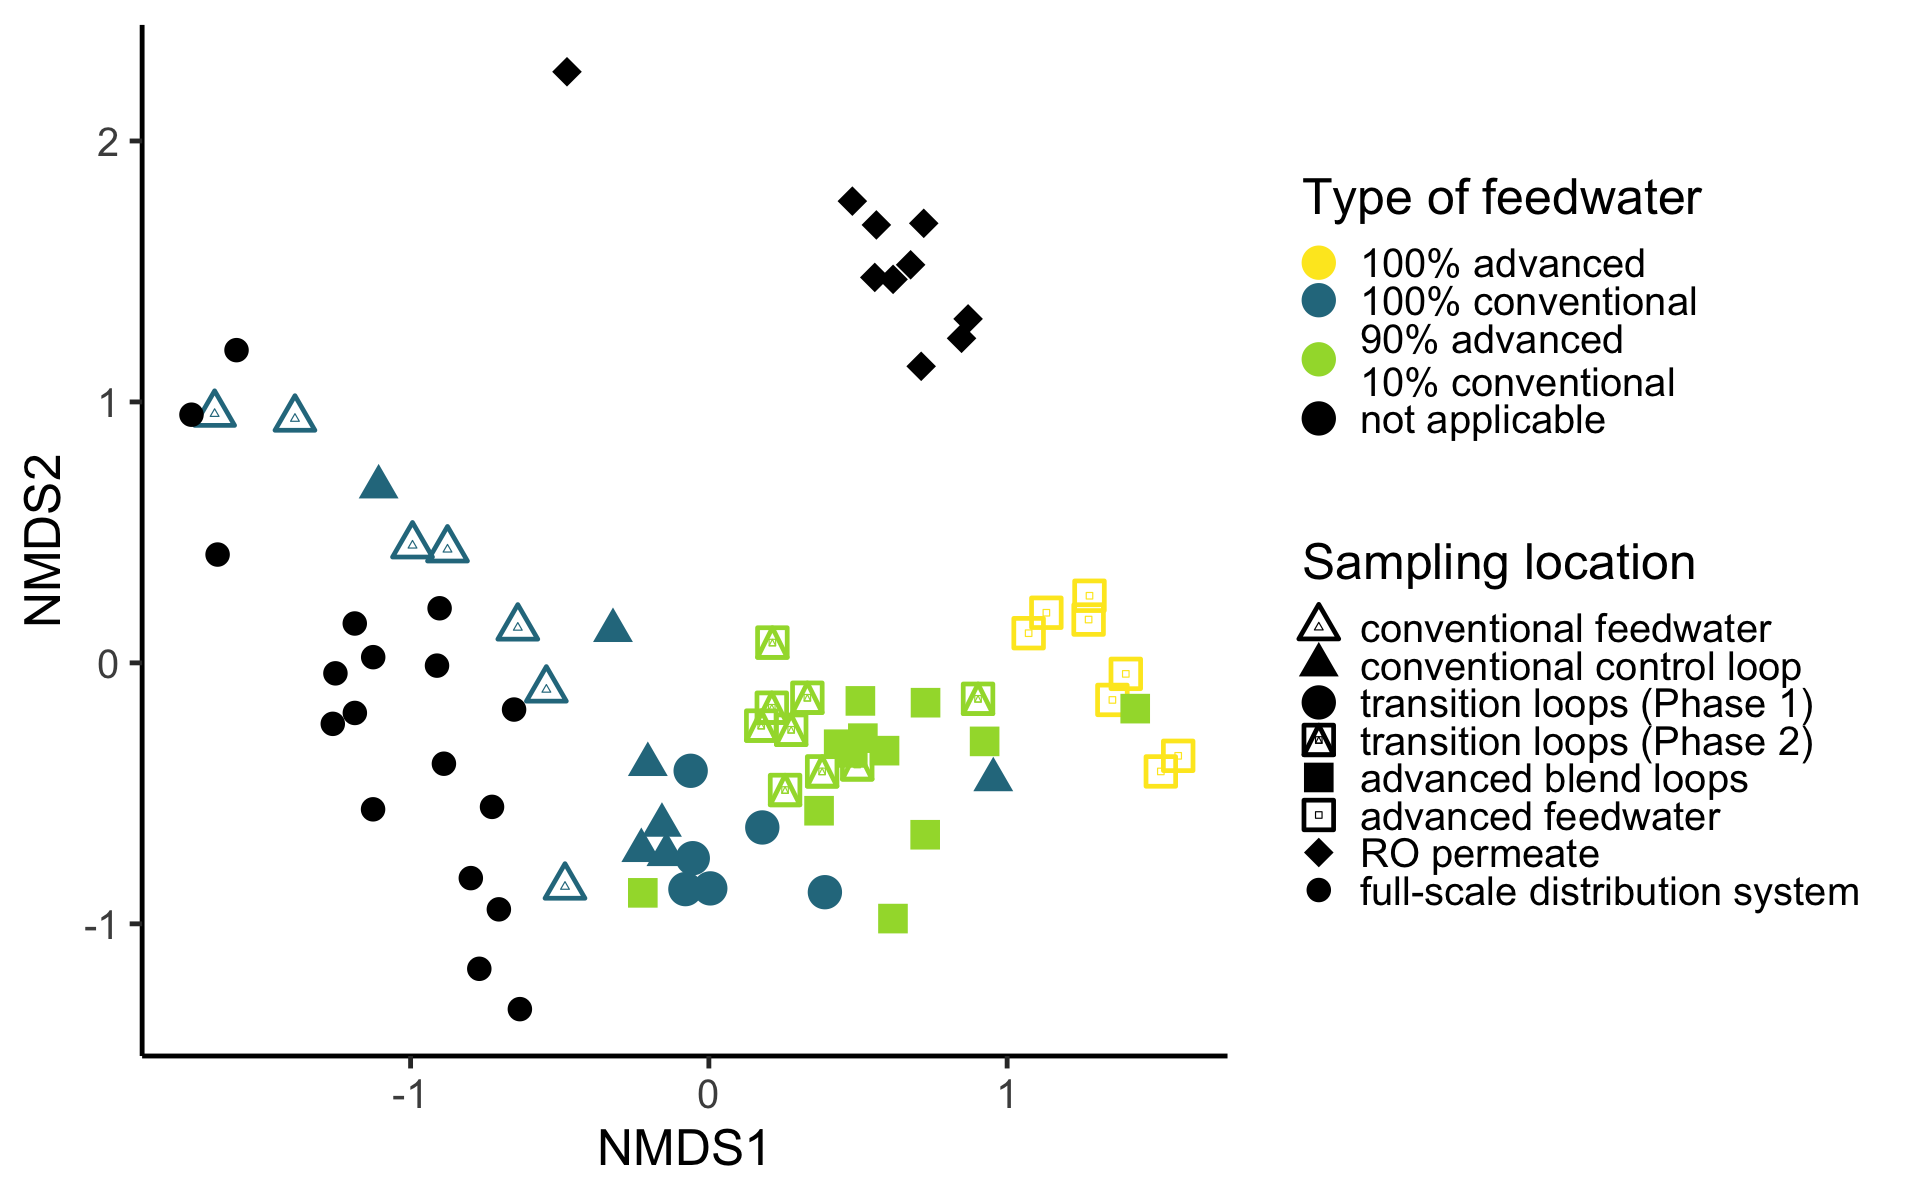

In [14]:
theme_set(theme_classic(base_size=30))#, base_line_size= 1))
loops_full=c( "#FDE724","#2A788D", "#A2DA38","black")
loops_full_key=c("#2A788D", "#2A788D", "#2A788D", "#A2DA38","#A2DA38","#FDE724","black","black")
loops_full1=c( "white","white", "white","black")
loops_full2=c( "#FDE724","#2A788D", "white","black")


a<- pipe_loop_all_perc
sample_data(a)$adj_loc<- as.character(sample_data(a)$adj_loc)
sample_data(a)[sample_data(a)$adj_loc == "full-scale\ndistribution system", "adj_loc"]<-"full-scale distribution system"
sample_data(a)$adj_loc<- factor(sample_data(a)$adj_loc, levels=c("conventional feedwater", "conventional control loop", p1, p2,"advanced blend loops","advanced feedwater","RO permeate","full-scale distribution system"))
bulk.pcoa.bray <- ordinate(a, method="NMDS", distance="bray")
options(repr.plot.width = 16, repr.plot.height = 10) #for plotting size in jupyter
plt<-plot_ordination(a, bulk.pcoa.bray, color="influent_composition", shape="adj_loc")+ geom_point(size=7, stroke=2)+
    scale_shape_manual(values=c(2,17,19,14,15,0,18,20))+
    scale_color_manual(values = loops_full)+
    labs(color='Type of feedwater', shape="Sampling location")

plt
ggsave("/Users/owner/Desktop/PL-NMDS.png", device= "png", width=16, height=10)

In [15]:
a<-pipe_loop_b_perc


unique(sample_data(a)$influent_composition)
sm=10
lg=12
bulk.pcoa.bray <- ordinate(a, method="NMDS", distance="bray", trymax= 300)
options(repr.plot.width = 8, repr.plot.height = 8) #for plotting size in jupyter
pltA<-plot_ordination(a, bulk.pcoa.bray, color="influent_composition", shape="adj_loc")+ geom_point(size=3,stroke=1)+
    scale_shape_manual(values=c(2,17,19,14,15,0,18,20))+
    scale_color_manual(values = loops_full)+
    scale_fill_manual(values = loops_full)+
    labs(color='type of\nfeedwater', shape="sampling location")+
     guides(shape=guide_legend(nrow=3))+
    theme(legend.position='bottom',legend.box='vertical',legend.margin=margin(t=-10),axis.text.y = element_text( hjust = 0, vjust=0, size=lg), axis.text.x = element_text(size=sm), axis.title= element_text(size=lg), legend.text=element_text(size=sm),legend.title=element_text(size=sm))


[1] "100% conventional"              "90% advanced\n10% conventional"
[3] "100% advanced"

Square root transformation
Wisconsin double standardization
Run 0 stress 0.1491016 
Run 1 stress 0.1511034 
Run 2 stress 0.1640166 
Run 3 stress 0.1622056 
Run 4 stress 0.1491015 
... New best solution
... Procrustes: rmse 0.0001019142  max resid 0.0005916776 
... Similar to previous best
Run 5 stress 0.1491699 
... Procrustes: rmse 0.004034316  max resid 0.02294958 
Run 6 stress 0.1493479 
... Procrustes: rmse 0.006989126  max resid 0.02582002 
Run 7 stress 0.1493501 
... Procrustes: rmse 0.007278504  max resid 0.02659091 
Run 8 stress 0.1513891 
Run 9 stress 0.1622055 
Run 10 stress 0.1707086 
Run 11 stress 0.1640166 
Run 12 stress 0.1493499 
... Procrustes: rmse 0.007290869  max resid 0.02663913 
Run 13 stress 0.1617461 
Run 14 stress 0.1640182 
Run 15 stress 0.14935 
... Procrustes: rmse 0.007313306  max resid 0.0267069 
Run 16 stress 0.1493423 
... Procrustes: rmse 0.006435538  max resid 0.02503561 
Run 17 stress 0.1727356 
Run 18 stress 0.1727824 
Run 19 stress 0.1491017 
... Pro

In [16]:
a<-pipe_loop_bfm_bulk_perc

sample_data(a)<-sample_data(a)[sample_data(a)$adj_loc %in% c(p1,p2),]

sample_data(a)[sample_data(a)$influent_composition ==  '90% advanced\n10%_conventional', "influent_composition"] <- '90% advanced\n10% conventional'
sample_data(a)[sample_data(a)$influent_composition ==  '100%_conventional_water', "influent_composition"] <- '100% conventional'
sample_data(a)[sample_data(a)$influent_composition ==  '90%_conditioned/10%_conventional', "influent_composition"] <- '90% advanced\n10% conventional'
unique(sample_data(a)$influent_composition)
sm=10
lg=12
bulk.pcoa.bray <- ordinate(a, method="NMDS", distance="bray", trymax= 300)
options(repr.plot.width = 8, repr.plot.height = 8) #for plotting size in jupyter
pltB<-plot_ordination(a, bulk.pcoa.bray, color="influent_composition", shape="sample_type")+ geom_point(size=3,stroke=1)+
    scale_shape_manual(values=c(19,1))+
    scale_color_manual(values = loops_full[2:3])+
    scale_fill_manual(values = loops_full[2:3])+
   labs(color='sample date', shape="sampling location")+
     guides(shape=guide_legend(nrow=3))+
    theme(legend.position='bottom',legend.margin=margin(t=-10),legend.box='vertical',axis.text.y = element_text( hjust = 0, vjust=0, size=lg), axis.text.x = element_text(size=sm), axis.title= element_text(size=lg), legend.text=element_text(size=sm),legend.title=element_text(size=sm))


[1] "90% advanced\n10% conventional" "100% conventional"

Square root transformation
Wisconsin double standardization
Run 0 stress 0.1731022 
Run 1 stress 0.1774716 
Run 2 stress 0.1740812 
Run 3 stress 0.1740599 
Run 4 stress 0.1731023 
... Procrustes: rmse 7.907318e-05  max resid 0.000318186 
... Similar to previous best
Run 5 stress 0.1731023 
... Procrustes: rmse 0.0003214932  max resid 0.001330228 
... Similar to previous best
Run 6 stress 0.1964806 
Run 7 stress 0.1819158 
Run 8 stress 0.1740595 
Run 9 stress 0.1838767 
Run 10 stress 0.1774714 
Run 11 stress 0.1848622 
Run 12 stress 0.1774714 
Run 13 stress 0.1757159 
Run 14 stress 0.1801591 
Run 15 stress 0.1801599 
Run 16 stress 0.1839419 
Run 17 stress 0.1774712 
Run 18 stress 0.1774713 
Run 19 stress 0.1904631 
Run 20 stress 0.1801277 
*** Solution reached


In [17]:
y=pipe_loop_bfm_bulk
sample_data(y)<-sample_data(y)[sample_data(y)$adj_loc %in% c(p1,p2),]
bulk_bray = phyloseq::distance(y, "bray")
bulk_sample_info = as(sample_data(y), "data.frame")
adonis2(bulk_bray ~  sample_type +influent_composition +sample_date , bulk_sample_info)

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
sample_type,1,0.6636737,0.09102051,3.138847,0.002
influent_composition,1,0.3926195,0.05384639,1.856895,0.046
sample_date,1,0.3148969,0.04318700,1.489306,0.124
Residual,28,5.9202842,0.81194610,NA,NA
Total,31,7.2914744,1.00000000,NA,NA


In [18]:
y=pipe_loop_b
bulk_bray = phyloseq::distance(y, "bray")
bulk_sample_info = as(sample_data(y), "data.frame")
adonis2(bulk_bray ~ influent_composition + sample_date , bulk_sample_info)

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
influent_composition,3,4.936943,0.27418986,6.885332,0.001
sample_date,1,0.401210,0.02228255,1.678648,0.094
Residual,53,12.667411,0.70352758,NA,NA
Total,57,18.005564,1.00000000,NA,NA


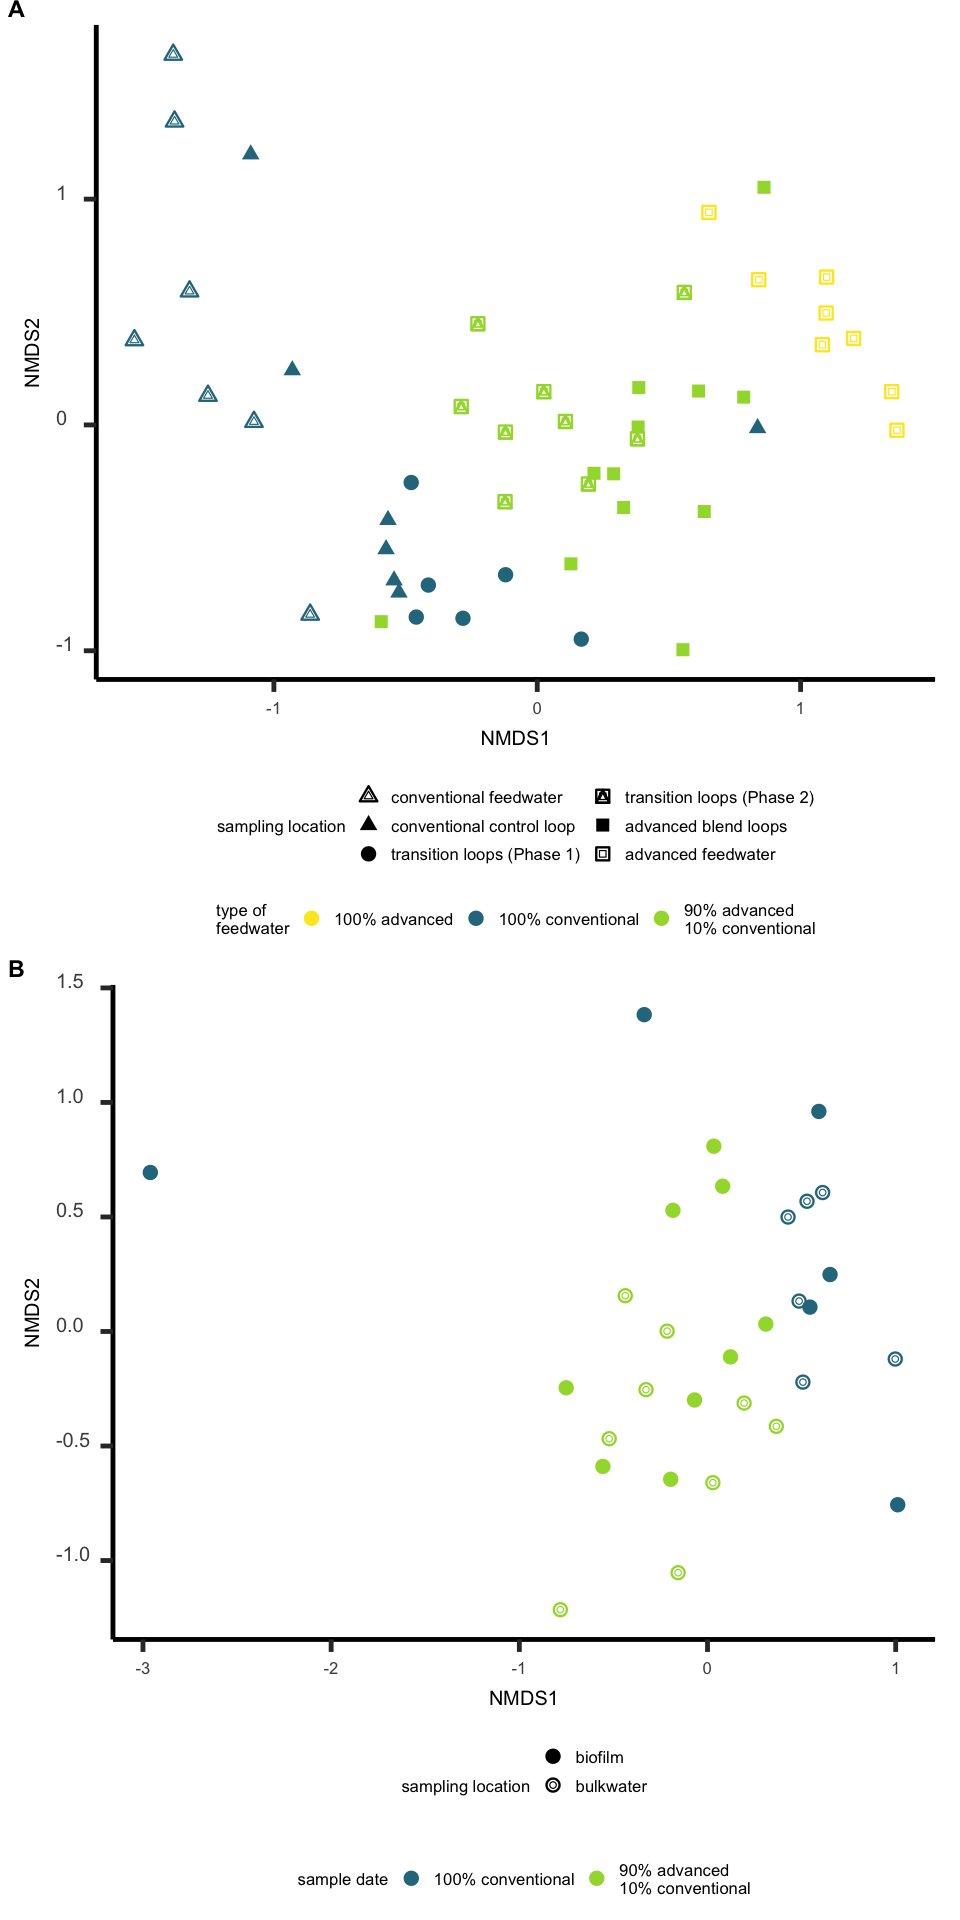

In [19]:
options(repr.plot.width =8, repr.plot.height = 16) #for plotting size in jupyter

ggarrange(pltA, pltB,
          labels = c("A", "B"),
           ncol = 1, nrow = 2, vjust=1,common.legend=FALSE)
ggsave("/Users/owner/Desktop/PL-hmbiofilm.png", device= "png", width=6, height=10, units='in', dpi=600, limitsize=FALSE)

## Differential abundance

In [20]:
sample_data(pipe_loop_bfm_bulk_filter)$phase_fin <- as.character(sample_data(pipe_loop_bfm_bulk_filter)$Phase)
sample_data(pipe_loop_bfm_bulk_filter)[sample_data(pipe_loop_bfm_bulk_filter)$Phase == "Phase 2a", "phase_fin"]<-"Phase_2"
sample_data(pipe_loop_bfm_bulk_filter)[sample_data(pipe_loop_bfm_bulk_filter)$Phase == "Phase 2b", "phase_fin"]<-"Phase_2"
sample_data(pipe_loop_bfm_bulk_filter)[sample_data(pipe_loop_bfm_bulk_filter)$Phase == "Phase 1", "phase_fin"]<-"Phase_1"
sample_data(pipe_loop_bfm_bulk_filter)$adj_loc_o<-sample_data(pipe_loop_bfm_bulk_filter)$adj_loc
sample_data(pipe_loop_bfm_bulk_filter)$phase_fin <- as.factor(sample_data(pipe_loop_bfm_bulk_filter)$phase_fin)
sample_data(pipe_loop_bfm_bulk_filter)$adj_loc<- as.character(sample_data(pipe_loop_bfm_bulk_filter)$adj_loc)
sample_data(pipe_loop_bfm_bulk_filter)$adj_loc<- gsub(" ", "_", sample_data(pipe_loop_bfm_bulk_filter)$adj_loc)
sample_data(pipe_loop_bfm_bulk_filter)$adj_loc<- sub("[\r\n]", ".", sample_data(pipe_loop_bfm_bulk_filter)$adj_loc)
sample_data(pipe_loop_bfm_bulk_filter)$adj_loc<- sub("[(]", "", sample_data(pipe_loop_bfm_bulk_filter)$adj_loc)
sample_data(pipe_loop_bfm_bulk_filter)$adj_loc<- sub("[)]", "", sample_data(pipe_loop_bfm_bulk_filter)$adj_loc)
sample_data(pipe_loop_bfm_bulk_filter)$adj_loc<- factor(sample_data(pipe_loop_bfm_bulk_filter)$adj_loc)
test<-pipe_loop_bfm_bulk_filter
test<-subset_samples(test, (location_code == "transition_loops"))
test <- filter_taxa(test, filterfun(kOverA(1,0.05)), TRUE) #one sample,5 perc.

pipe_loop_bfm_bulk_filter_ps<- phyloseq_to_deseq2(test,  ~location_code_orig+sample_type+phase_fin) #it doesn't make sense to add date or time because it confounds with phase
pipe_loop_bfm_bulk_filter_ps$phase_fin <- relevel(pipe_loop_bfm_bulk_filter_ps$phase_fin, ref = "Phase_1")
pipe_loop_bfm_bulk_filter_ps = DESeq(pipe_loop_bfm_bulk_filter_ps, test="Wald", fitType='local', sfType="poscounts") # local had the most reasonable fit in dispersion estimates, poscoundt b/c phyloseq 

res <- results(pipe_loop_bfm_bulk_filter_ps,  cooksCutoff = TRUE) 
summary(res)
alpha = 0.05
sigtab = res[which(res$padj < alpha), ]
sigtab = cbind(as(sigtab, "data.frame"), as(tax_table(pipe_loop_bfm_bulk_filter)[rownames(sigtab), ], "matrix"))
head(sigtab)
dim(sigtab)


converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing




out of 571 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 20, 3.5%
LFC < 0 (down)     : 6, 1.1%
outliers [1]       : 82, 14%
low counts [2]     : 363, 64%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Kingdom,Phylum,Class,Order,Family,Genus,combined,num,test,full_name
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
AGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGTTATATAAGACAGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCATTTGTGACTGTATAGCTAGAGTACGGCAGAGGGGGATGGAATTCCGCGTGTAGCAGTGAAATGCGTAGATATGCGGAGGAACACCGATGGCGAAGGCAATCCCCTGGGCCTGTACTGACGCTCATGCACGAAAGCGTGGGGAGCAAACA,4401.57818,-2.391123,0.6894557,-3.468131,5.240915e-04,4.402369e-03,Bacteria,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,Burkholderiaceae,Acidovorax,Proteobacteria>Burkholderiaceae>Acidovorax,5,Burkholderiaceae_Acidovorax,Burkholderiaceae_Acidovorax_5
AGGGAGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCACGTAGGCGGCTTTTTAAGTCAGGGGTGAAATCCCGGGGCTCAACCCCGGAACTGCCCTTGAAACTGGGAAGCTAGAATCTTGGAGAGGCGAGTGGAATTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAAGAACACCAGTGGCGAAGGCGACTCGCTGGACAAGTATTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACA,400.30222,4.318946,0.9388299,4.600350,4.217817e-06,5.904944e-05,Bacteria,Proteobacteria,Alphaproteobacteria,Sphingomonadales,Sphingomonadaceae,Porphyrobacter,Proteobacteria>Sphingomonadaceae>Porphyrobacter,11,Sphingomonadaceae_Porphyrobacter,Sphingomonadaceae_Porphyrobacter_11
AGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGCTTTGCAAGACAGAGGTGAAATCCCCGGGCTCAACCTGGGAACTGCCTTTGTGACTGCAAGGCTAGAGTACGGCAGAGGGGGATGGAATTCCGCGTGTAGCAGTGAAATGCGTAGATATGCGGAGGAACACCGATGGCGAAGGCAATCCCCTGGGCCTGTACTGACGCTCATGCACGAAAGCGTGGGGAGCAAACA,71.82544,-11.480582,2.9763880,-3.857220,1.146841e-04,1.111553e-03,Bacteria,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,Burkholderiaceae,Aquabacterium,Proteobacteria>Burkholderiaceae>Aquabacterium,12,Burkholderiaceae_Aquabacterium,Burkholderiaceae_Aquabacterium_12
AGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGTTTTGTAAGACAGGCGTGAAATCCCCGGGCTCAACCTGGGAATTGCGCTTGTGACTGCAAAGCTGGAGTGCGGCAGAGGGGGATGGAATTCCGCGTGTAGCAGTGAAATGCGTAGATATGCGGAGGAACACCGATGGCGAAGGCAATCCCCTGGGCCTGCACTGACGCTCATGCACGAAAGCGTGGGGAGCAAACA,72.99674,8.700760,1.0695360,8.135079,4.116688e-16,2.593513e-14,Bacteria,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,Burkholderiaceae,Hydrogenophaga,Proteobacteria>Burkholderiaceae>Hydrogenophaga,16,Burkholderiaceae_Hydrogenophaga,Burkholderiaceae_Hydrogenophaga_16
AGGGGGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCACGTAGGCGGCGATTTAAGTCAGAGGTGAAAGCCCGGGGCTCAACCCCGGAACTGCCTTTGAGACTGGATTGCTTGAATCCGGGAGAGGTGAGTGGAATTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAAGAACACCAGTGGCGAAGGCGGCTCACTGGACCGGCATTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACA,287.41025,5.376046,1.0026055,5.362075,8.227116e-08,1.480881e-06,Bacteria,Proteobacteria,Alphaproteobacteria,Sphingomonadales,Sphingomonadaceae,Sphingobium,Proteobacteria>Sphingomonadaceae>Sphingobium,17,Sphingomonadaceae_Sphingobium,Sphingomonadaceae_Sphingobium_17
AGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGTGGTTCAGCAAGTTGGAGGTGAAATCCCCGGGCTCAACCTGGGAACTGCCTCCAAAACTACTGAGCTAGAGTACGGTAGAGGGTAGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAGGAACACCAGTGGCGAAGGCGACTACCTGGACTGATACTGACACTGAGGTGCGAAAGCGTGGGGAGCAAACA,236.80830,8.231090,1.4874672,5.533628,3.136744e-08,6.587161e-07,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas,Proteobacteria>Pseudomonadaceae>Pseudomonas,24,Pseudomonadaceae_Pseudomonas,Pseudomonadaceae_Pseudomonas_24


[1] 21 16

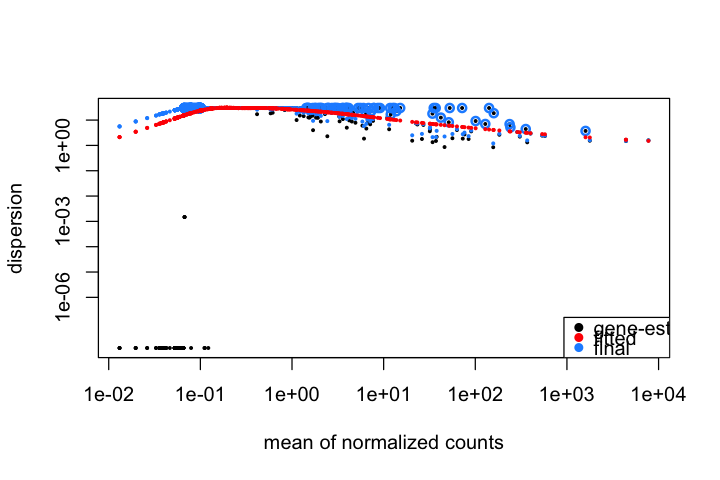

In [21]:
options(repr.plot.width = 6, repr.plot.height = 4) #for plotting size in jupyter
plotDispEsts(pipe_loop_bfm_bulk_filter_ps)

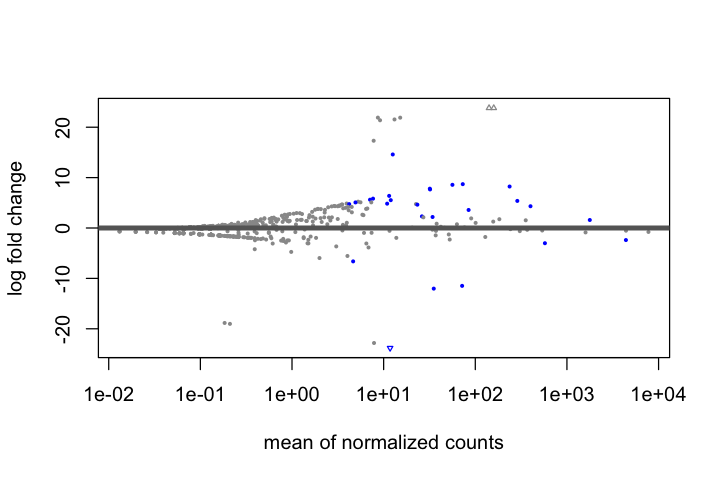

In [22]:
plotMA(pipe_loop_bfm_bulk_filter_ps)

Warning message in `[<-.factor`(`*tmp*`, iseq, value = c("Unknown", "Unknown")):
“invalid factor level, NA generated”


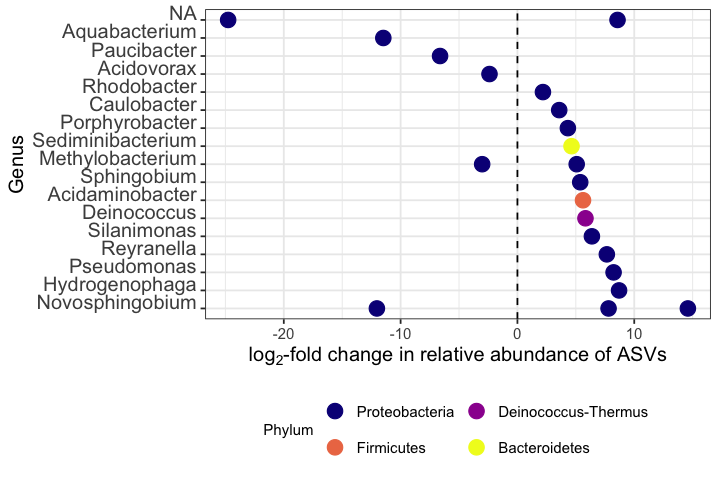

In [23]:
options(repr.plot.width = 6, repr.plot.height = 4) #for plotting size in jupyter
lg=12
sm=9


# Phylum order
x = tapply(sigtab$log2FoldChange, sigtab$Phylum, function(x) max(x))
x = sort(x, TRUE)
sigtab$Phylum = factor(as.character(sigtab$Phylum), levels=names(x))
# Genus order
x = tapply(sigtab$log2FoldChange, sigtab$Genus, function(x) max(x))
x = sort(x, TRUE)

sigtab$Genus = factor(as.character(sigtab$Genus), levels=names(x))
sigtab[is.na(sigtab$Genus),"Genus"]<- "Unknown"

ggplot(sigtab, aes(y=Genus, x=log2FoldChange, color=Phylum)) + geom_point(size=4) +
        
  xlab(bquote(log[2]*"-fold change in relative abundance of ASVs"))+
  theme_bw()+
  scale_color_viridis_d(option="plasma")+
  geom_vline(xintercept=0, linetype='dashed')+
  guides(color=guide_legend(nrow=2,byrow=TRUE))+
  theme(legend.position='bottom',axis.text.y = element_text( hjust = 1, vjust=0, size=lg), axis.text.x = element_text(size=sm), axis.title= element_text(size=lg), legend.text=element_text(size=sm),legend.title=element_text(size=sm))
ggsave("/Users/owner/Desktop/deseq_results.png", device= 'png',width=6, dpi=600, height=4, units="in")

In [24]:
change<-rownames(sigtab)
length(change)

[1] 21

## Heat maps

In [25]:
set_week_start("Monday") # set the default start of the week
sample_data(pipe_loop_bfm_bulk_inf_perc)$week<-factor_aweek(as.aweek(sample_data(pipe_loop_bfm_bulk_inf_perc)$sample_date))
sample_data(pipe_loop_bfm_bulk_inf_perc)$week_loop<- paste0(sample_data(pipe_loop_bfm_bulk_inf_perc)$location_code_orig,"-",sample_data(pipe_loop_bfm_bulk_inf_perc)$week)

sample_data(pipe_loop_bfm_bulk_inf_perc)[sample_data(pipe_loop_bfm_bulk_inf_perc)$influent_composition == '100%_conventional_water', "influent_composition"]<- "100% conventional"
sample_data(pipe_loop_bfm_bulk_inf_perc)[sample_data(pipe_loop_bfm_bulk_inf_perc)$influent_composition == '90%_conditioned/10%_conventional', "influent_composition" ]<- '90% advanced\n10%_conventional'



In [26]:

heat_filt<-prune_taxa(change,pipe_loop_bfm_bulk_inf_perc) 
levels(sample_data(heat_filt)$adj_loc)
levels(sample_data(heat_filt)$adj_loc)<-c('conventional feedwater','conventional control loop','conventional phase\nof transition loops','advanced blend phase\nof transition loops','advanced blend loops', "advanced feedwater")
sample_data(heat_filt)<-sample_data(heat_filt)[sample_data(heat_filt)$sample_type=='biofilm']

theme_set(theme_classic(base_size=8))#, base_line_size= 1))
options(repr.plot.width = max_h_in, repr.plot.height = max_w_in)
plta<-plot_heatmap(heat_filt, taxa.label = "new", sample.label = "week_loop", sample.order = "week", method="PCoA")+
     theme(axis.text.y = element_text(size=6),
           axis.text.x = element_text(size=6.5, angle = 45, hjust = 1, vjust = 1),
           axis.title.y = element_blank(), 
           axis.title.x = element_blank(),
           axis.ticks = element_blank())+
     facet_grid(sample_type~adj_loc+influent_composition, scale="free_x" )+
    viridis::scale_fill_viridis(name="Percent\nAbundance", option="plasma",trans="sqrt", , limits = c(0,80))+
    theme(legend.title = element_text(color = "black", size = 8),
          legend.text = element_text(color = "black", size= 8))#legend.key.size = unit(3, "cm"))
                                     
ord<-ggplot_build(plta)$layout$panel_params[[1]]$y$breaks

[1] "conventional feedwater"     "conventional control loop" 
[3] "transition loops (Phase 1)" "transition loops (Phase 2)"
[5] "advanced blend loops"       "advanced feedwater"

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



In [27]:
heat_filt<-prune_taxa(change,pipe_loop_bfm_bulk_inf_perc) 
levels(sample_data(heat_filt)$adj_loc)
levels(sample_data(heat_filt)$adj_loc)<-c('conventional feedwater','conventional control loop','conventional phase\nof transition loops','advanced blend phase\nof transition loops','advanced blend loops', "advanced feedwater")
sample_data(heat_filt)<-sample_data(heat_filt)[sample_data(heat_filt)$sample_type=='bulkwater']

theme_set(theme_classic(base_size=8))#, base_line_size= 1))
options(repr.plot.width = max_h_in, repr.plot.height = max_w_in)
pltb<-plot_heatmap(heat_filt, taxa.label = "new", sample.label = "week_loop", sample.order = "week", taxa.order=ord)+
    theme(axis.text.y = element_text(size=6),
           axis.text.x = element_text(size=6.5, angle = 45, hjust = 1, vjust = 1),
           axis.title.y = element_blank(),
           axis.title.x = element_blank(),
           axis.ticks = element_blank())+
     facet_grid(sample_type~adj_loc+influent_composition, scale="free_x" )+
    viridis::scale_fill_viridis(name="Percent\nAbundance", option="plasma",trans="sqrt", limits = c(0,80))+
    theme(legend.title = element_text(color = "black", size = 8),
          legend.text = element_text(color = "black", size= 8))#legend.key.size = unit(3, "cm"))


[1] "conventional feedwater"     "conventional control loop" 
[3] "transition loops (Phase 1)" "transition loops (Phase 2)"
[5] "advanced blend loops"       "advanced feedwater"

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



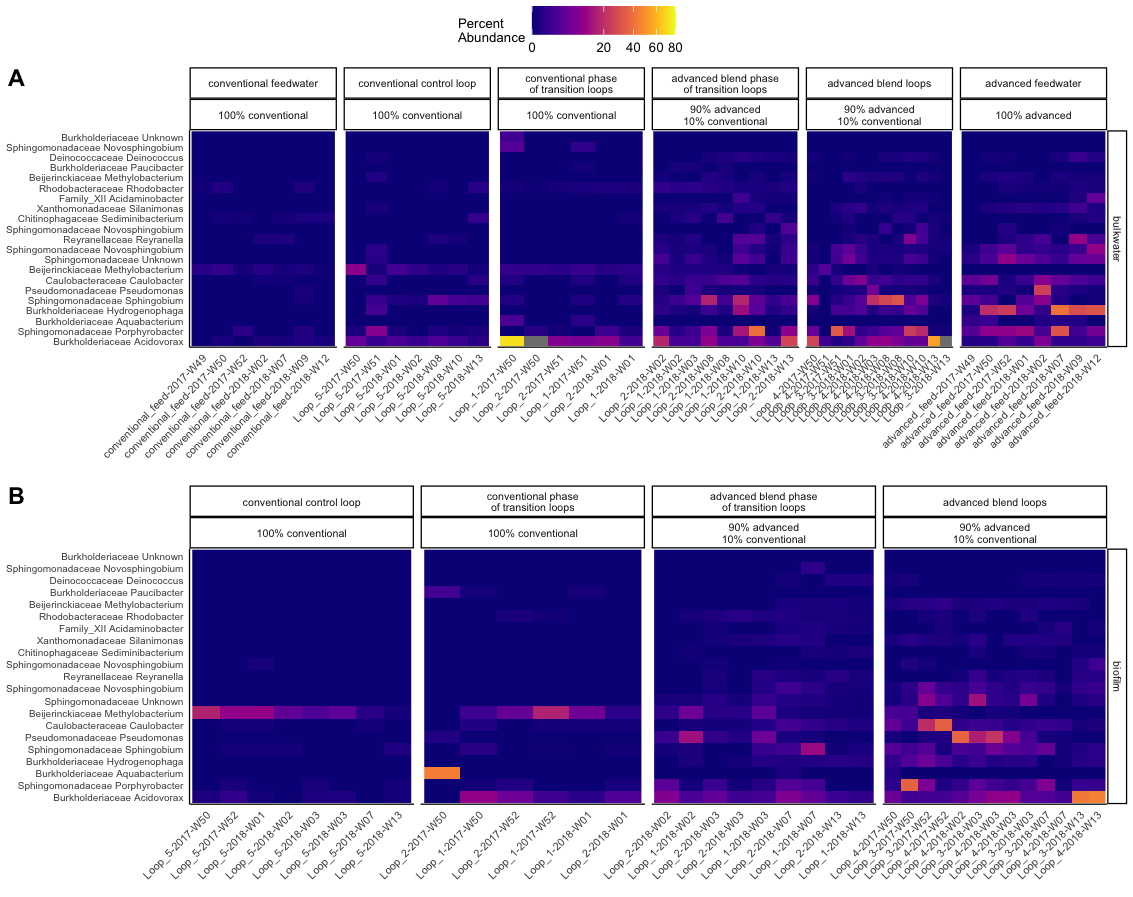

In [28]:
ggarrange(pltb, plta,
          labels = c("A", "B"),
           ncol = 1, nrow = 2, common.legend=TRUE)
ggsave("/Users/owner/Desktop/PL-hmbiofilm.png", device= "png", width=max_h, height=max_w, units='mm', dpi=600, limitsize=FALSE)

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



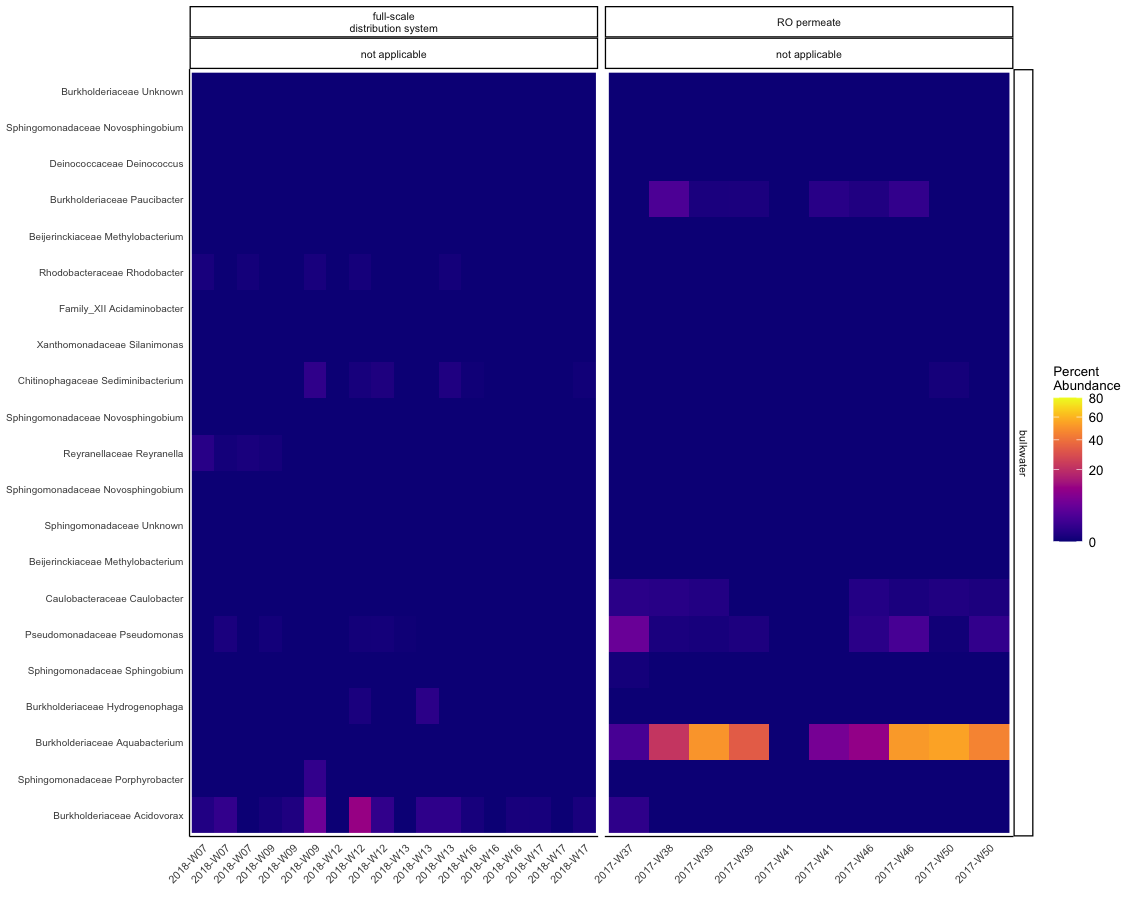

In [29]:
set_week_start("Monday") # set the default start of the week
sample_data(pipe_loop_all_perc)$week<-factor_aweek(as.aweek(sample_data(pipe_loop_all_perc)$sample_date))
sample_data(pipe_loop_all_perc)$week_loop<- paste0(sample_data(pipe_loop_all_perc)$location_code_orig,"-",sample_data(pipe_loop_all_perc)$week)
heat_filt<-prune_taxa(change,pipe_loop_all_perc) 
heat_filt <- transform_sample_counts(heat_filt, function(x) x+0.0001)#just to show in log scale
sample_data(heat_filt)<- sample_data(heat_filt)[sample_data(heat_filt)$influent_composition=="not applicable",]
sample_data(heat_filt)$adj_loc<-factor(sample_data(heat_filt)$adj_loc, levels=c("full-scale\ndistribution system","RO permeate"))

                                     
theme_set(theme_classic(base_size=8))#, base_line_size= 1))
options(repr.plot.width = max_h_in, repr.plot.height = max_w_in)
pltc<-plot_heatmap(heat_filt, taxa.label = "new", sample.label = "week", sample.order = "week", method="PCoA", taxa.order=ord)+
     theme(axis.text.y = element_text(size=6),
           axis.text.x = element_text(size=6.5, angle = 45, hjust = 1, vjust = 1),
           axis.title.y = element_blank(), 
           axis.title.x = element_blank(),
           axis.ticks = element_blank())+
     facet_grid(sample_type~adj_loc+influent_composition, scale="free_x" )+
    viridis::scale_fill_viridis(name="Percent\nAbundance", option="plasma",trans="sqrt", , limits = c(0,80))+
    theme(legend.title = element_text(color = "black", size = 8),
          legend.text = element_text(color = "black", size= 8))#legend.key.size = unit(3, "cm"))
pltc                                 
                                

In [30]:
min_abund <- 50 #reads
min_samples <- 1

dataset <- pipe_loop_bfm_bulk_filter
dataset_bfm<-subset_samples(dataset, (sample_type == "biofilm"))
dataset_blk<-subset_samples(dataset, (sample_type == "bulkwater"))

## Opportunistic Pathogen Genera

In [31]:
bulk_pathogen_p <- subset_taxa(pipe_loop_all_perc, Genus=="Pseudomonas")
bulk_pathogen_p<- prune_taxa(change, bulk_pathogen_p)

tax_table(bulk_pathogen_p) #Pseudomonas 24 was significantly upregulated in the transition loops (when both bulk and biofilm were considered) in phase 2

,Kingdom,Phylum,Class,Order,Family,Genus,combined,num,test,full_name,num2,new,full_name_2,name_opp
AGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGTGGTTCAGCAAGTTGGAGGTGAAATCCCCGGGCTCAACCTGGGAACTGCCTCCAAAACTACTGAGCTAGAGTACGGTAGAGGGTAGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAGGAACACCAGTGGCGAAGGCGACTACCTGGACTGATACTGACACTGAGGTGCGAAAGCGTGGGGAGCAAACA,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas,Proteobacteria>Pseudomonadaceae>Pseudomonas,24,Pseudomonadaceae_Pseudomonas,Pseudomonadaceae_Pseudomonas_24,24,Pseudomonadaceae Pseudomonas,Pseudomonadaceae Pseudomonas 24,Pseudomonas 24


In [32]:

##Legionella
col<-c("SG", "SGPI", "pH", "total_Cl2_mg.L","free_Cl2_mg.L","influent_composition","location_code","adj_loc", "sample_date","location_code_orig","sample_type")
#get ranges of relative abundances for each location
bulk_pathogen <- subset_taxa(pipe_loop_all_perc, Genus=="Legionella")
bulk_pathogen <- filter_taxa(bulk_pathogen, filterfun(kOverA(1, 0.05)), TRUE) #remove any really low OTUs potentially from barcode bleed



taxa_names(bulk_pathogen)<-tax_table(bulk_pathogen)[,14]
samples<- as.data.frame(sample_data(bulk_pathogen))[,col]
species<- as.data.frame(otu_table(bulk_pathogen))
# species<-as.data.frame(t(species))
comb<-cbind(species,samples)
comb[, 1:(length(comb)-length(col))]<- comb[, 1:(length(comb)-length(col))]/100 * comb$SG #continuous values

melted<-reshape2::melt(comb,na.rm=TRUE,id.vars=col)
melted_leg=melted
melted_leg$genus_comb<-"Legionella-classified ASVs"
pathogen_abs_abund_range <- as.data.frame(melted %>% group_by(adj_loc) %>% summarise( m=max(value), n_positive=sum( value> 0), n=n(), distinct=n_distinct()))
pathogen_abs_abund_range$m <-signif(pathogen_abs_abund_range$m, digits = 2)
pathogen_abs_abund_range$m <-scientific(pathogen_abs_abund_range$m, digits = 2)
pathogen_abs_abund_range$Genera<-"Legionella"
leg<-pathogen_abs_abund_range


#pseudomonas
bulk_pathogen <- subset_taxa(pipe_loop_all_perc, Genus=="Pseudomonas")
bulk_pathogen <- filter_taxa(bulk_pathogen, filterfun(kOverA(1, 0.05)), TRUE) #remove any really low OTUs potentially from barcode bleed

taxa_names(bulk_pathogen)<-tax_table(bulk_pathogen)[,14]
samples<- as.data.frame(sample_data(bulk_pathogen))[,col]
species<- as.data.frame(otu_table(bulk_pathogen))

comb<-cbind(species,samples)
comb[, 1:(length(comb)-length(col))]<- comb[, 1:(length(comb)-length(col))]/100 * comb$SG #continuous values

melted<-reshape2::melt(comb,na.rm=TRUE,id.vars=col)
melted_pse=melted
melted_pse$genus_comb<-"Pseudomonas-classified ASVs"
pathogen_abs_abund_range <- as.data.frame(melted %>% group_by(adj_loc) %>% summarise( m=max(value), n_positive=sum( value> 0), n=n(), distinct=n_distinct()))
pathogen_abs_abund_range$m <-signif(pathogen_abs_abund_range$m, digits = 2)
pathogen_abs_abund_range$m <-scientific(pathogen_abs_abund_range$m, digits = 2)
pathogen_abs_abund_range$Genera<-"Pseudomonas"
pse<-pathogen_abs_abund_range

#mycobacterium
bulk_pathogen <- subset_taxa(pipe_loop_all_perc, Genus=="Mycobacterium")
bulk_pathogen <- filter_taxa(bulk_pathogen, filterfun(kOverA(1, 0.05)), TRUE) #remove any really low OTUs potentially from barcode bleed

taxa_names(bulk_pathogen)<-tax_table(bulk_pathogen)[,14]
samples<- as.data.frame(sample_data(bulk_pathogen))[,col]
species<- as.data.frame(otu_table(bulk_pathogen))

comb<-cbind(species,samples)
comb[, 1:(length(comb)-length(col))]<- comb[, 1:(length(comb)-length(col))]/100 * comb$SG #continuous values

melted<-reshape2::melt(comb,na.rm=TRUE,id.vars=col)
melted_myc=melted
melted_myc$genus_comb<-"Mycobacterium-classified ASVs"
pathogen_abs_abund_range <- as.data.frame(melted %>% group_by(adj_loc) %>% summarise( m=max(value), n_positive=sum( value> 0), n=n(), distinct=n_distinct()))
pathogen_abs_abund_range$m <-signif(pathogen_abs_abund_range$m, digits = 2)
pathogen_abs_abund_range$m <-scientific(pathogen_abs_abund_range$m, digits = 2)

pathogen_abs_abund_range$Genera<-"Mycobacterium"
myc<-pathogen_abs_abund_range

pathogen_possible=rbind(myc,pse,leg)
pathogen_possible
bulk_path<-rbind(melted_myc, melted_pse,melted_leg)


adj_loc,m,n_positive,n,distinct,Genera
<fct>,<chr>,<int>,<int>,<int>,<chr>
conventional feedwater,1.3e+04,22,126,0,Mycobacterium
conventional control loop,3.0e+04,46,126,0,Mycobacterium
transition loops (Phase 1),1.6e+04,28,108,0,Mycobacterium
transition loops (Phase 2),1.7e+04,50,162,0,Mycobacterium
advanced blend loops,4.2e+04,82,216,0,Mycobacterium
advanced feedwater,1.5e+03,9,144,0,Mycobacterium
RO permeate,4.1e+02,66,180,0,Mycobacterium
full-scale distribution system,1.0e+03,55,324,0,Mycobacterium
conventional feedwater,9.5e+01,4,91,0,Pseudomonas


`summarise()` has grouped output by 'variable', 'adj_loc',
'influent_composition', 'genus_comb'. You can override using the `.groups`
argument.
Joining, by = c("influent_composition", "adj_loc", "sample_type", "variable",
"genus_comb")
Warning message:
“Removed 4 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 4 rows containing missing values (geom_point).”
Warning message:
“Removed 4 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 4 rows containing missing values (geom_point).”


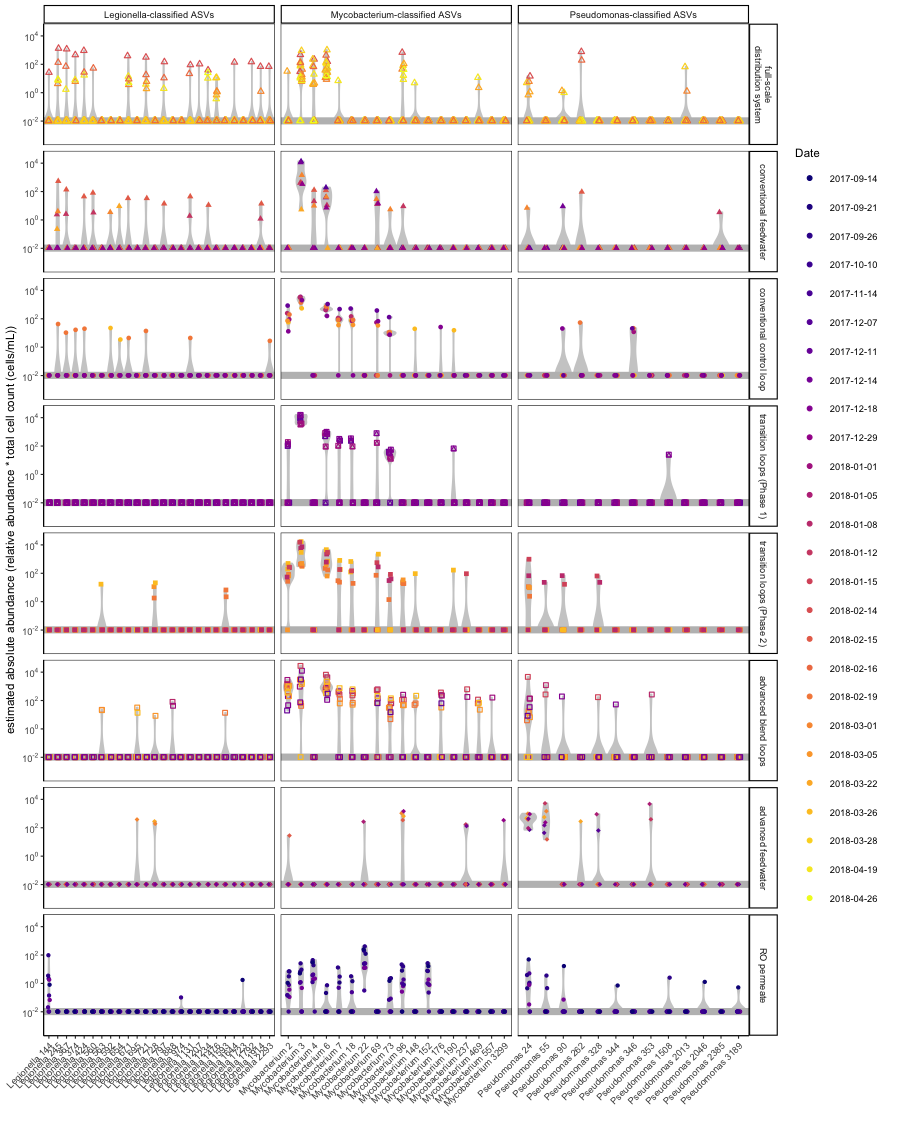

In [33]:
theme_set(theme_classic(base_size=28))#, base_line_size= 1))
minv= min(bulk_path[bulk_path$value!=0,]$value) *0.5
give.n <- function(x){
return(c(y = minv, label = length(x))) 
# experiment with the multiplier to find the perfect position
}

b=bulk_path
b[b$value==0,"value"]<-minv
stats_df=b %>% group_by( variable, adj_loc, influent_composition,genus_comb, sample_type) %>% summarise(n = n(), g=sum(value > minv))
stats_df$p=round((stats_df$g/stats_df$n)*100,1)

b<-left_join(b,stats_df)
# create equidistant sequence of dates to use as labels
lab_dates <- pretty(b$sample_date)
b$sample_date<- as.factor(b$sample_date)

b$adj_loc <- factor(b$adj_loc,levels=  c("full-scale\ndistribution system", "conventional feedwater", "conventional control loop", "transition loops (Phase 1)", "transition loops (Phase 2)",  "advanced blend loops", "advanced feedwater", "RO permeate")) 

theme_set(theme_classic(base_size=7))#, base_line_size= 1))
options(repr.plot.width = max_w_in, repr.plot.height = max_h_in)
ggplot(b, aes(x=variable, y=value))+
    geom_violin( color='#CDCDCD', fill='#CDCDCD') + 
    geom_hline(yintercept=minv, size=2, color='grey')+
    geom_jitter(aes(shape=adj_loc, color=sample_date), width=0.1, stroke=0.5,size=1)+
    scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x),
                labels = trans_format("log10", math_format(10^.x)), limits=c(0.0005,30000 )) +
ylab("estimated absolute abundance (relative abundance * total cell count (cells/mL))")  +
xlab("")+
scale_shape_manual(values=c(2,17,16,14,15,0,18,20))+
scale_colour_viridis_d(option='plasma')+
facet_grid('adj_loc~genus_comb', scales='free_x')+
guides(fill="none", shape="none", color=guide_legend(ncol=1))+
labs(shape="", color="Date")+
theme(legend.position='right',panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),  
      axis.text.x = element_text(angle = 45, hjust = 1)) 


ggsave("/Users/owner/Desktop/PL-OPPs.png", device= "png", width=max_w, height=max_h, units='mm', dpi=600, limitsize=FALSE)

In [34]:

col<-c("SG", "SGPI", "pH", "total_Cl2_mg.L","free_Cl2_mg.L","influent_composition","location_code","adj_loc", "sample_date","location_code_orig","sample_type")
bulk_pathogen1 <- subset_taxa(pipe_loop_all_perc, Genus %in% c("Pseudomonas", "Mycobacterium","Legionella"))
bulk_pathogen2 <- subset_taxa(pipe_loop_bfm_bulk_perc, Genus %in% c("Pseudomonas", "Mycobacterium","Legionella"))
bulk_pathogen2<- subset_samples(bulk_pathogen2, sample_type=="biofilm")
bulk_pathogen<-merge_phyloseq(bulk_pathogen1, bulk_pathogen2)
sample_data(bulk_pathogen)[sample_data(bulk_pathogen)$sample_type==1, "sample_type"]<- "biofilm"
bulk_pathogen <- filter_taxa(bulk_pathogen, filterfun(kOverA(1, 0.05)), TRUE) #remove any really low OTUs potentially from barcode bleed
samples<- as.data.frame(sample_data(bulk_pathogen))[,col]
samples[samples$location_code_orig == "RO_2stage", "location_code_orig"]<- "RO"
samples[samples$location_code_orig == "RO_3stage", "location_code_orig"]<- "RO"

#myco
bulk_pathogen_m<- subset_taxa(bulk_pathogen, Genus== "Mycobacterium")
taxa_names(bulk_pathogen_m)<-tax_table(bulk_pathogen_m)[,14]
species_m<- as.data.frame(otu_table(bulk_pathogen_m))
species_m$num_pos_m<-rowSums(species_m>0)
species_m$Mycobacterium<-NA
species_m[species_m$num_pos_m == 0, "Mycobacterium"]<- 0
species_m[species_m$num_pos_m > 0, "Mycobacterium"]<- 1
species_m<-species_m[,c("num_pos_m","Mycobacterium")]

#legionella
bulk_pathogen_l<- subset_taxa(bulk_pathogen, Genus== "Legionella")
taxa_names(bulk_pathogen_l)<-tax_table(bulk_pathogen_l)[,14]
species_l<- as.data.frame(otu_table(bulk_pathogen_l))
species_l$num_pos_l<-rowSums(species_l>0)
species_l$Legionella<-NA
species_l[species_l$num_pos_l == 0, "Legionella"]<- 0
species_l[species_l$num_pos_l > 0, "Legionella"]<- 1
species_l<-species_l[,c("num_pos_l","Legionella")]

#pseudomonas
bulk_pathogen_p<- subset_taxa(bulk_pathogen, Genus== "Pseudomonas")
taxa_names(bulk_pathogen_p)<-tax_table(bulk_pathogen_p)[,14]
species_p<- as.data.frame(otu_table(bulk_pathogen_p))
species_p$num_pos_p<-rowSums(species_p>0)
species_p$Pseudomonas<-NA
species_p[species_p$num_pos_p == 0, "Pseudomonas"]<- 0
species_p[species_p$num_pos_p > 0, "Pseudomonas"]<- 1
species_p<-species_p[,c("num_pos_p","Pseudomonas")]

comb<-cbind(species_m,species_l, species_p, samples)

stats_df2=comb %>% group_by(location_code_orig, adj_loc, influent_composition, sample_type) %>% summarise(n = n(), Legionella=sum(Legionella),  Pseudomonas=sum(Pseudomonas),  Mycobacterium=sum(Mycobacterium))
stats_df2=melt(stats_df2, id.vars = c("location_code_orig","adj_loc", "influent_composition","sample_type",  "n"), variable.name = "genus")
stats_df2$p=round((stats_df2$value/stats_df2$n)*100,1)
stats_df3=stats_df2 %>% group_by(adj_loc, influent_composition,genus,sample_type) %>% summarise(mean_p = mean(p), std_p  =  sd(p), count = n())

`summarise()` has grouped output by 'location_code_orig', 'adj_loc',
'influent_composition'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'adj_loc', 'influent_composition', 'genus'.
You can override using the `.groups` argument.


[1] "Legionella"    "Pseudomonas"   "Mycobacterium"

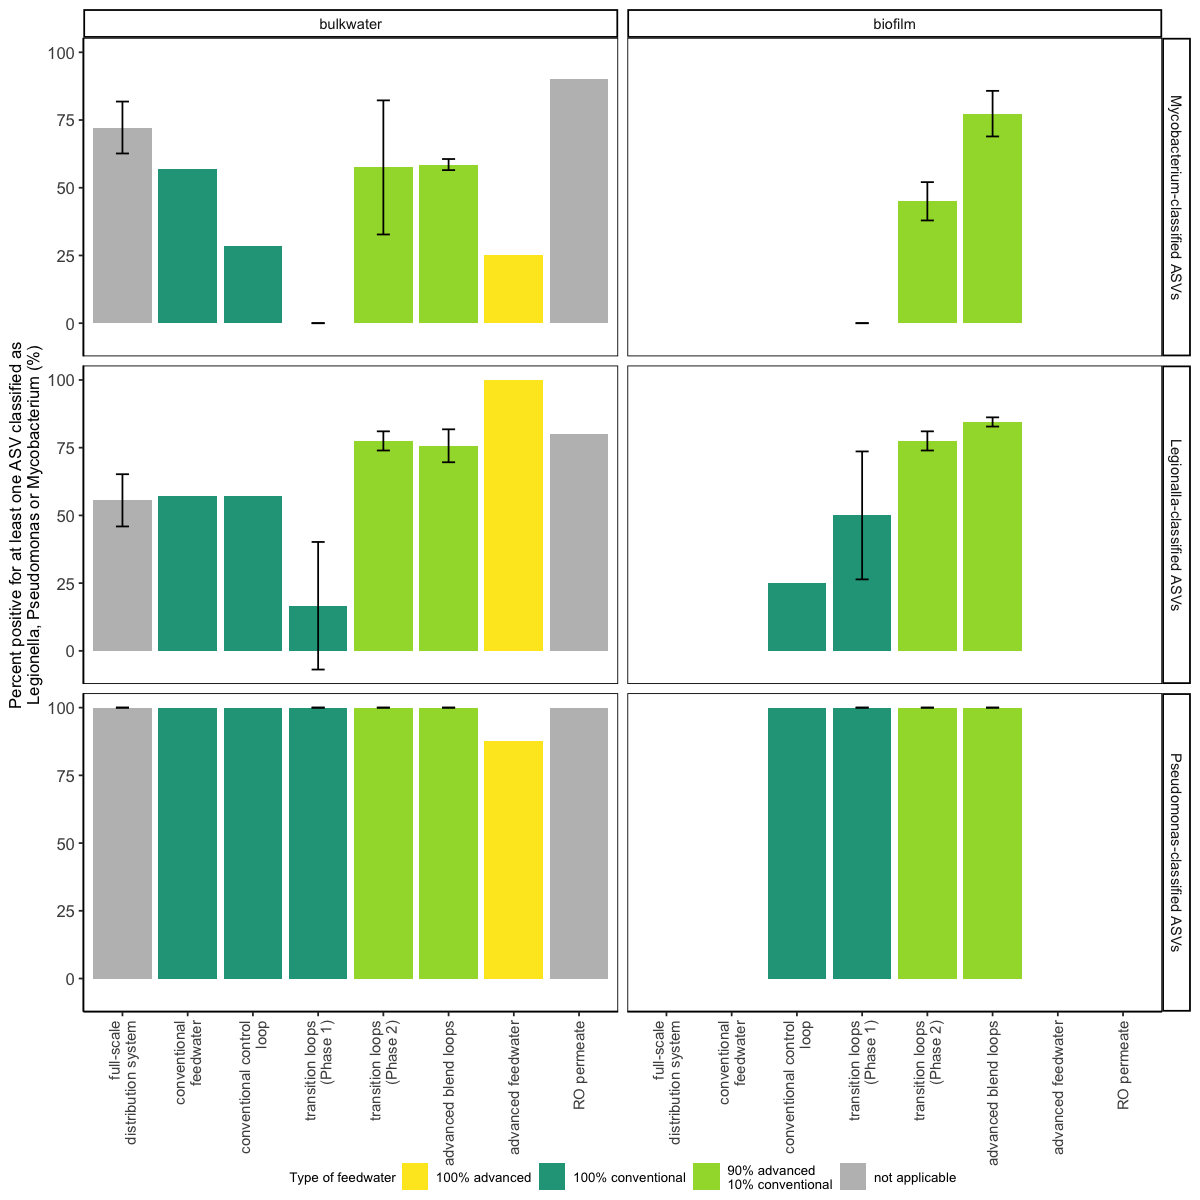

In [35]:
options(repr.plot.width = 10, repr.plot.height = 10) #change the size of the plot

boxplot_colors=c( "#FDE724", "#20A387","#A2DA38","grey")

theme_set(theme_classic(base_size=16))# set font size
a=stats_df3

a$adj_loc <-factor(a$adj_loc,c("full-scale\ndistribution system", "conventional feedwater", "conventional control loop", "transition loops (Phase 1)", "transition loops (Phase 2)",  "advanced blend loops", "advanced feedwater", "RO permeate")) 
a[a$influent_composition ==  '90% advanced\n10%_conventional', "influent_composition"] <- '90% advanced\n10% conventional'
a[a$influent_composition ==  '100%_conventional_water', "influent_composition"] <- '100% conventional'
a[a$influent_composition ==  '90%_conditioned/10%_conventional', "influent_composition"] <- '90% advanced\n10% conventional'
levels(a$genus)
levels(a$genus)<-c("Mycobacterium-classified ASVs","Legionalla-classified ASVs","Pseudomonas-classified ASVs")
a$sample_type<-  factor(a$sample_type,  levels= c("bulkwater","biofilm"))

ggplot(a, aes(x=adj_loc, y=mean_p, fill=influent_composition))+
    geom_bar(stat="identity")+
    geom_errorbar(aes(ymin = mean_p- std_p, ymax = mean_p+std_p), width = 0.2)+
    ylab("Percent positive for at least one ASV classified as\nLegionella, Pseudomonas or Mycobacterium (%)")+
    xlab("")+
    scale_fill_manual(values=boxplot_colors) +
    labs(fill='Type of feedwater') +
    facet_grid(genus~sample_type)+
    theme_classic()+
    # geom_text(aes(label=count), y=-8)+
          scale_x_discrete(labels = function(x) str_wrap(x, width = 20))+
    theme(panel.background = element_rect(fill="White", colour = "Black"), 
                axis.text.x = element_text(hjust=1, vjust=0.5,angle = 90, size = 9),
                axis.text.y  = element_text(size = 10),
                axis.title.x = element_text(size=10),
                axis.title.y = element_text(size=10),
                legend.title = element_text(size=8),
                legend.text = element_text(size=8),
                legend.box="vertical", legend.margin=margin(t=-25),
                legend.position= "bottom")
